# Video Surveillance for Violence Detection Using Deep Learning

Importing libraries:

In [1]:
import requests
import zipfile
import io
import numpy as np

import os
import cv2
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.applications import ResNet50, InceptionV3, VGG19
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow as tf
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

## Downloading Dataset

Downloading dataset:

In [2]:
# url = "https://www.dropbox.com/sh/pmqpxc6bbckwd1j/AAAh5iUjDRiDEg6CEHHSbqDna?dl=0"

# response = requests.get(url)
# response.raise_for_status()

Extracting dataset:

In [3]:
# zip_file = zipfile.ZipFile(io.BytesIO(response.content))
# zip_file.extractall("dataset")  
# zip_file.close()

## Reading Dataset and Exploration

### Reading Dataset

In [4]:
videos_directory = './HockeyFights'

video_paths = [os.path.join(videos_directory, video_path) 
               for video_path in os.listdir(videos_directory)]

Making labels array:

In [5]:
video_labels = np.array([(0 if video_path[0] == 'n' else 1) 
                for video_path in os.listdir(videos_directory)])

In [6]:
video_labels.shape

(1000,)

In [7]:
print(video_labels[:5], video_labels[497:502], video_labels[995:])

[1 1 1 1 1] [1 1 1 0 0] [0 0 0 0 0]


In [8]:
video_paths[0:5]

['./HockeyFights\\fi100_xvid.avi',
 './HockeyFights\\fi101_xvid.avi',
 './HockeyFights\\fi102_xvid.avi',
 './HockeyFights\\fi103_xvid.avi',
 './HockeyFights\\fi104_xvid.avi']

### Exploration

Finding the minimum and maximum number of frames in videos:

In [9]:
video_frames_count = [int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT)) 
                      for video_path in video_paths]

print('Maximum number of frames : ', max(video_frames_count), '  Image : ', 
      video_paths[video_frames_count.index(max(video_frames_count))])
print('Minumum number of frames : ', min(video_frames_count), '  Image : ', 
      video_paths[video_frames_count.index(min(video_frames_count))])

Maximum number of frames :  49   Image :  ./HockeyFights\fi190_xvid.avi
Minumum number of frames :  40   Image :  ./HockeyFights\fi157_xvid.avi


Number of frames of five random videos:

In [10]:
for i in range(5):
    video_c = cv2.VideoCapture(video_paths[random.randint(0, 999)])
    print('Number of video frame = ', 
          int(video_c.get(cv2.CAP_PROP_FRAME_COUNT)))

Number of video frame =  41
Number of video frame =  41
Number of video frame =  41
Number of video frame =  41
Number of video frame =  41


Videos height and width. Minimum and maximum: 

In [11]:
video_widths = [int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_WIDTH)) 
                      for video_path in video_paths]
video_heights = [int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_HEIGHT)) 
                      for video_path in video_paths]

print('Maximum videos widths : ', max(video_widths), '  Image : ', 
      video_paths[video_widths.index(max(video_widths))])
print('Minimum videos widths : ', min(video_widths), '  Image : ', 
      video_paths[video_widths.index(min(video_widths))])
print('Maximum videos heights : ', max(video_widths), '  Image : ', 
      video_paths[video_heights.index(max(video_heights))])
print('Minumum videos heights : ', min(video_heights), '  Image : ', 
      video_paths[video_heights.index(min(video_heights))])

Maximum videos widths :  360   Image :  ./HockeyFights\fi100_xvid.avi
Minimum videos widths :  360   Image :  ./HockeyFights\fi100_xvid.avi
Maximum videos heights :  360   Image :  ./HockeyFights\fi100_xvid.avi
Minumum videos heights :  288   Image :  ./HockeyFights\fi100_xvid.avi


Width and height of five random videos:

In [12]:
for i in range(5):
    video_c = cv2.VideoCapture(video_paths[random.randint(0, 999)])
    print('Width of video = ', 
          int(video_c.get(cv2.CAP_PROP_FRAME_WIDTH)))
    print('Height of video = ', 
          int(video_c.get(cv2.CAP_PROP_FRAME_HEIGHT)))

Width of video =  360
Height of video =  288
Width of video =  360
Height of video =  288
Width of video =  360
Height of video =  288
Width of video =  360
Height of video =  288
Width of video =  360
Height of video =  288


## Preprocessing

### Extract Frames

Making a numpy array to store 10 frames for each video:

In [13]:
frames_per_video = 20
height = 288
width = 360
channels = 3
number_of_images = 1000
max_numer_of_frames = 40

video_frames = np.empty((number_of_images, frames_per_video, height, width, channels), dtype=np.uint8)

Capturing videos and extract 10 frames from each:

In [14]:
for index, video_path in enumerate(video_paths):
    video_capture = cv2.VideoCapture(video_path)
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames // frames_per_video, 1)

    for frame_index in range(0, min(total_frames, max_numer_of_frames), frame_interval):
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        success, frame = video_capture.read()

        if success:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            video_frames[index][(frame_index // frame_interval)] = frame

    video_capture.release()

Shape of the result numpy array. It has 1000 rows, each for one video. Each row has 10 frames, and each frame has 3 channels and a 2D array with size of (288, 360):

In [15]:
video_paths = 0
video_frames.shape

(1000, 20, 288, 360, 3)

Showing five frames of one random video:

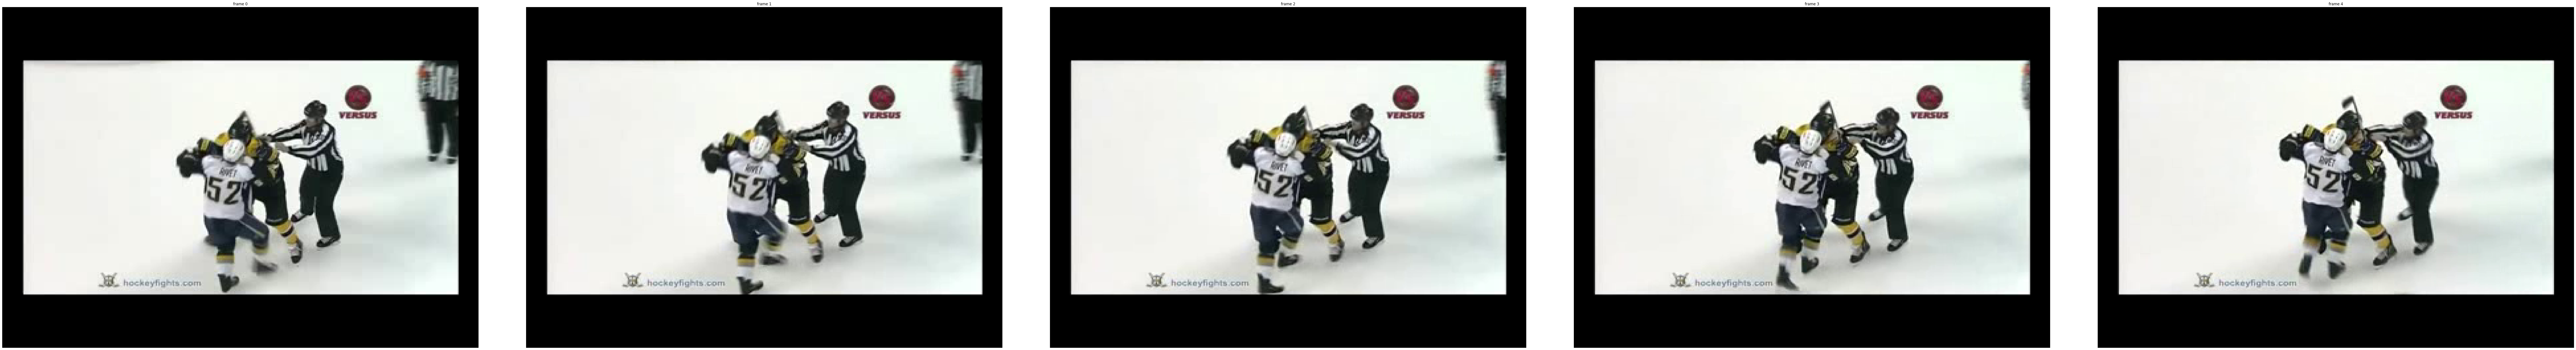

In [16]:
random_image_to_show = random.randint(0, 999)
fig, axes = plt.subplots(1, 5, figsize=(150, 20))

for i in range(5):
    axes[i].imshow(video_frames[random_image_to_show][i], aspect='auto')
    axes[i].axis('off')
    axes[i].set_title('frame ' + str(i))
plt.subplots_adjust(wspace=0.1)

plt.show()

### Augmentation

Function to remove dark edges:

In [17]:
def remove_dark_edges(image, threshold=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return crop

Checking if remove_dark_edges function works well:

Original image shape :  (288, 360, 3)
Preprocessed image shape :  (199, 331, 3)


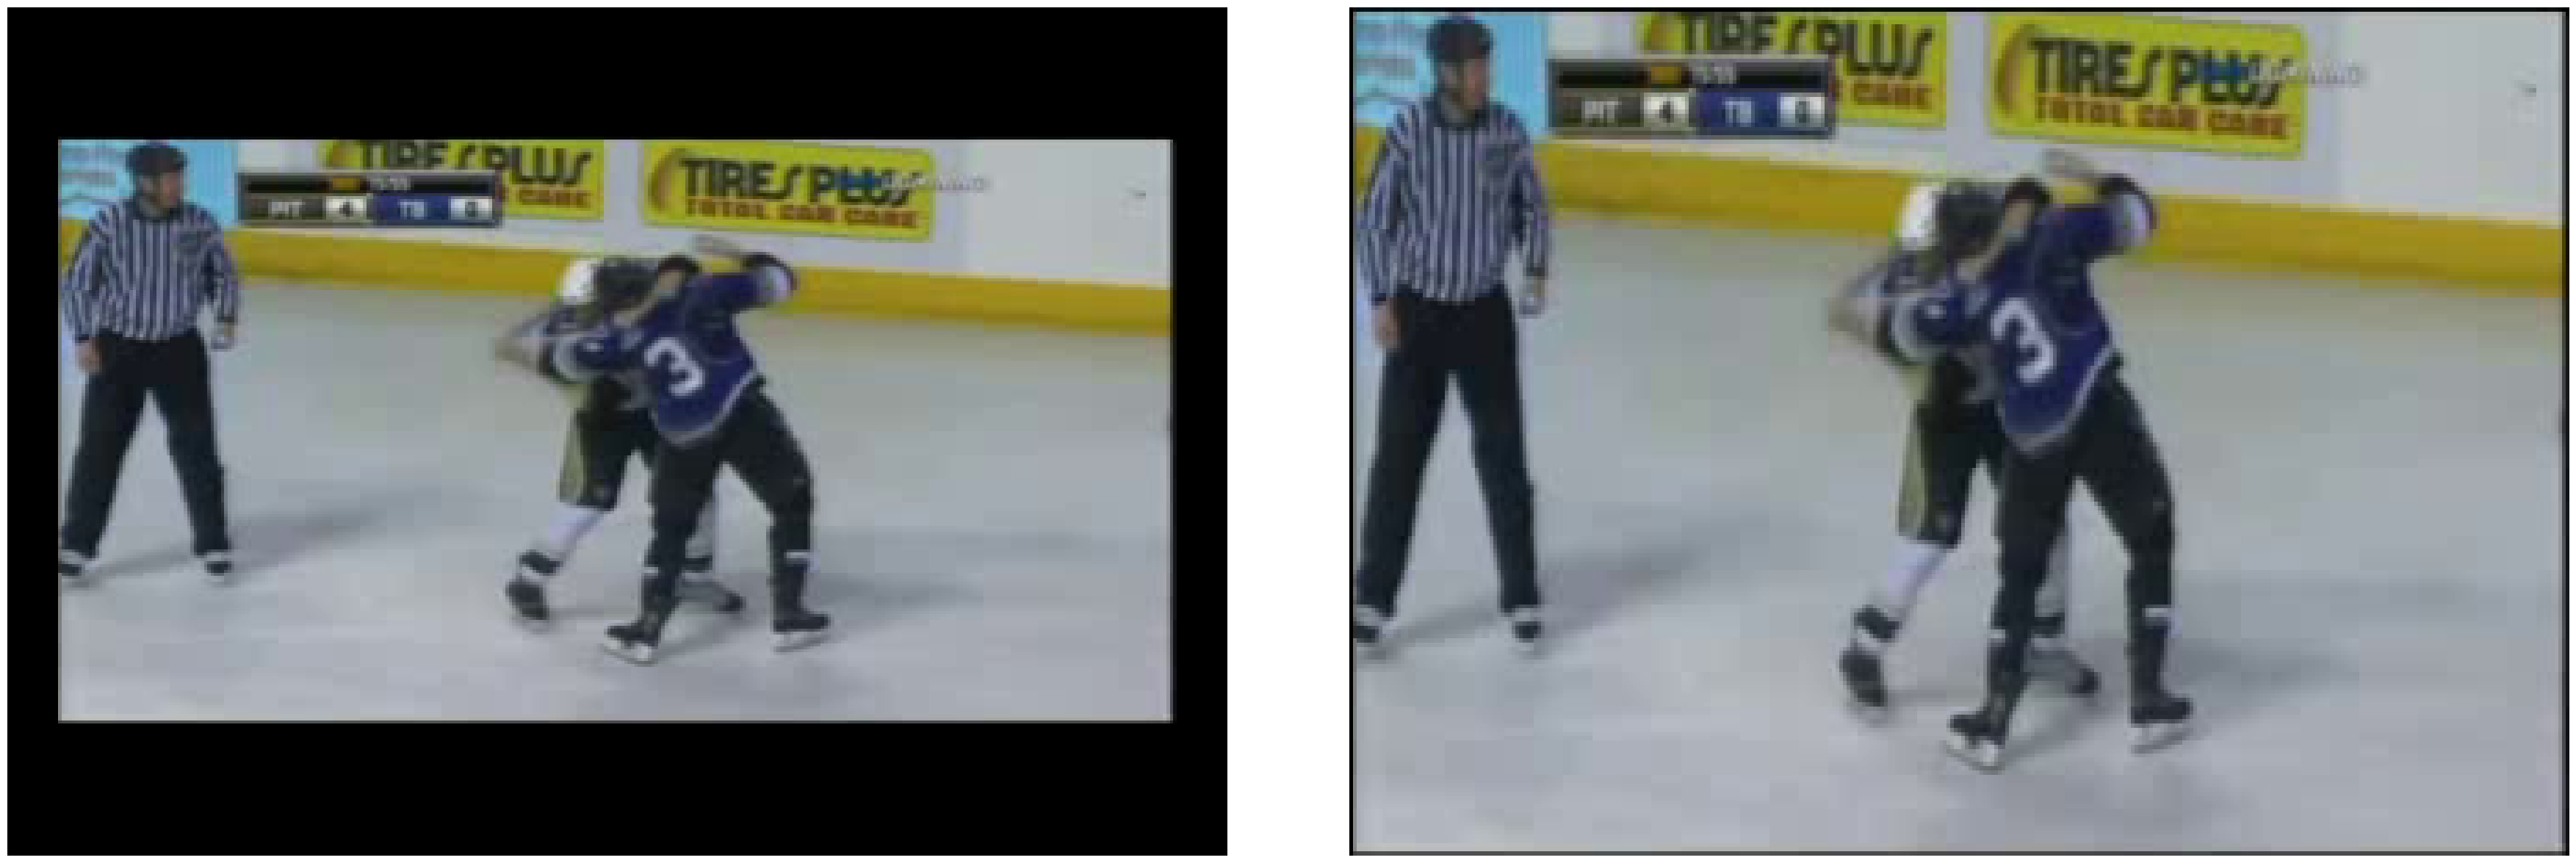

In [18]:
sample_image = video_frames[random.randint(0, 999)][0].copy()
processed_image = remove_dark_edges(sample_image)

print('Original image shape : ', sample_image.shape)
print('Preprocessed image shape : ', processed_image.shape)

fig, axes = plt.subplots(1, 2, figsize=(45, 15))
axes[0].imshow(sample_image, aspect='auto')
axes[0].axis('off')
axes[1].imshow(processed_image, aspect='auto')
axes[1].axis('off')
plt.subplots_adjust(wspace=0.1)

plt.show()

Function to randomly crop images:

In [19]:
def random_crop(image, crop_size):
    crop_types = ['top left', 'top right', 'bottom left', 'bottom right', 'center']
    random_crop_type = random.choice(crop_types)
    height, width = image.shape[:2]
    crop_width, crop_height = crop_size
    
    if random_crop_type == 'top left':
        x = 0
        y = 0
    elif random_crop_type == 'top right':
        x = width - crop_width
        y = 0
    elif random_crop_type == 'bottom left':
        x = 0
        y = height - crop_height
    elif random_crop_type == 'bottom right':
        x = width - crop_width
        y = height - crop_height
    elif random_crop_type == 'center':
        x = (width - crop_width) // 2
        y = (height - crop_height) // 2
    else:
        raise ValueError('Invalid crop type.')
    
    cropped_image = image[y:y+crop_height, x:x+crop_width]
    return cropped_image

Checking if random_crop function works well:

Original image shape :  (288, 360, 3)
Preprocessed image shape :  (200, 330, 3)


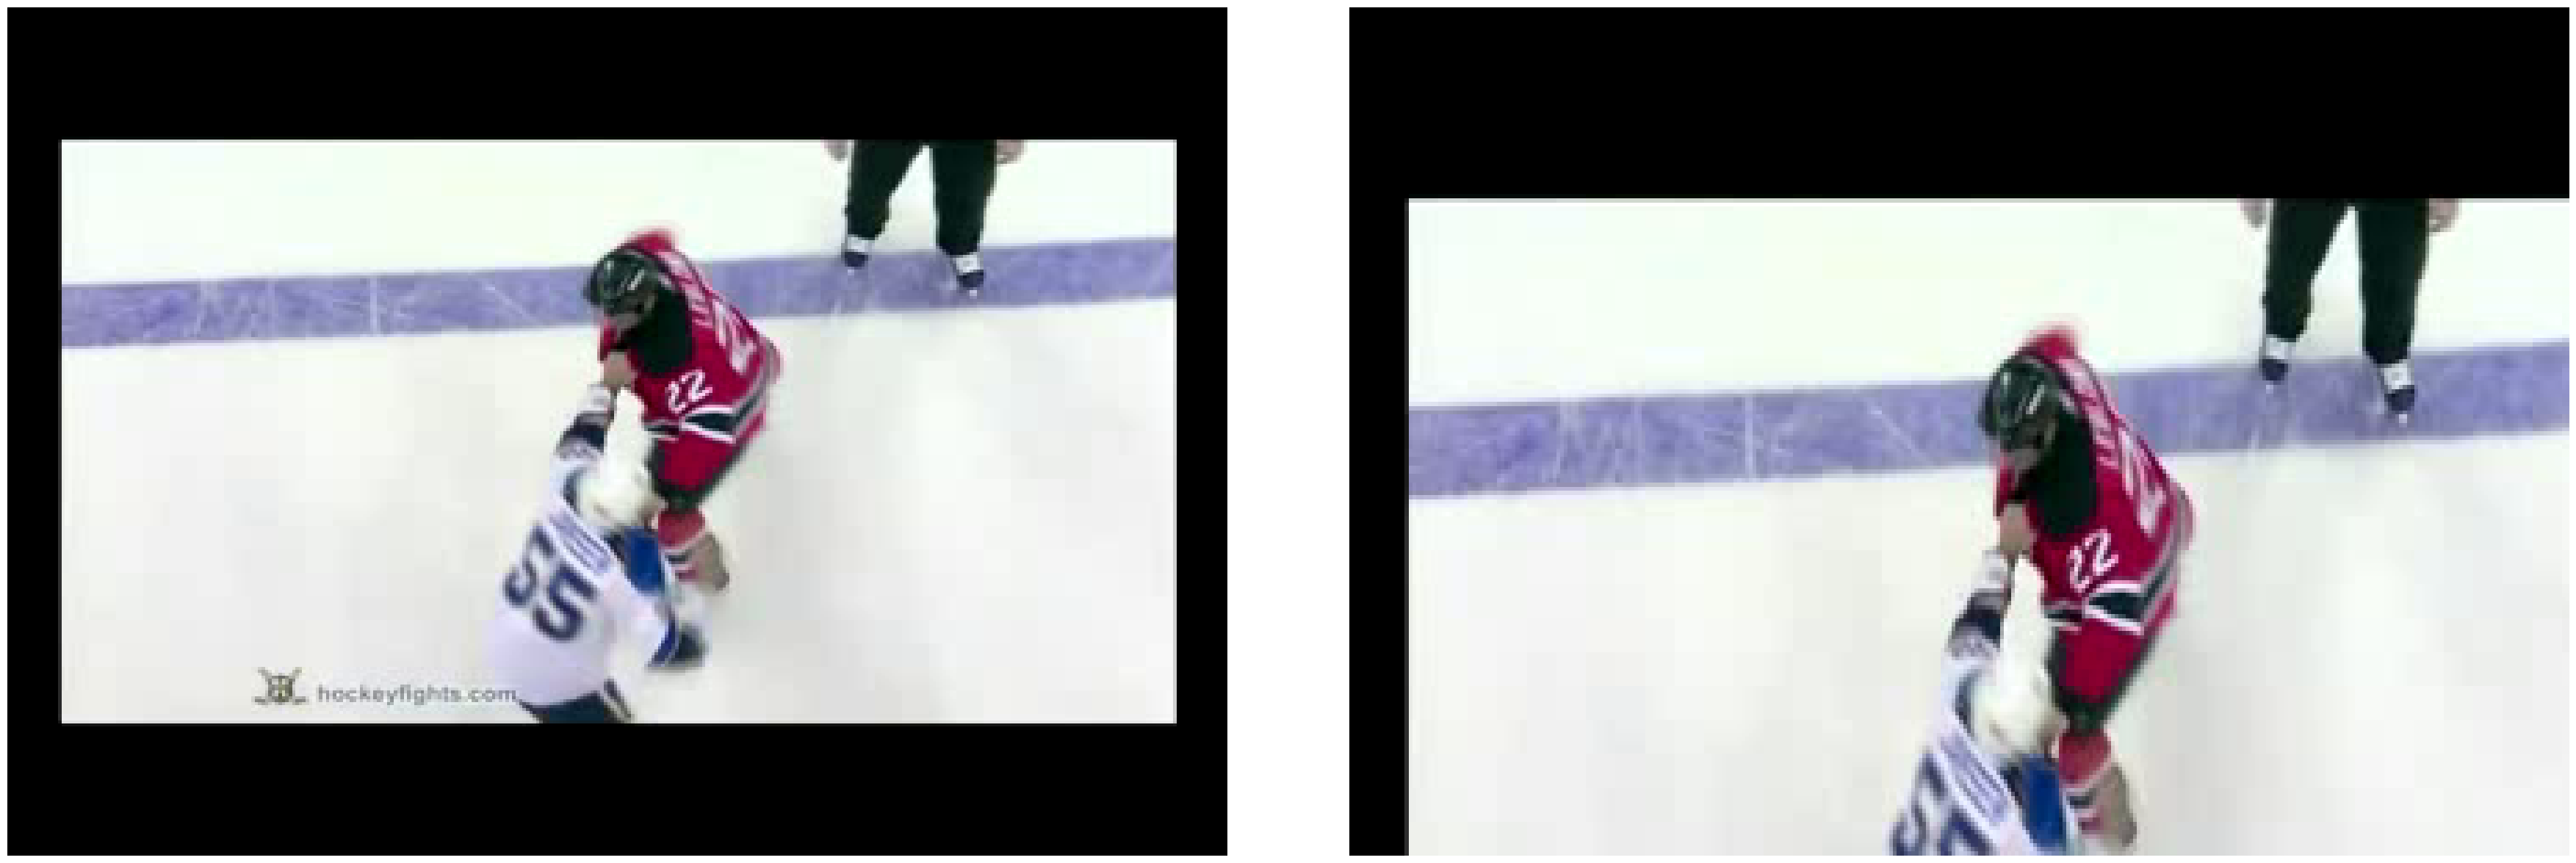

In [20]:
sample_image = video_frames[random.randint(0, 999)][0].copy()
crop_size = (330, 200)
cropped_image = random_crop(sample_image, crop_size)

print('Original image shape : ', sample_image.shape)
print('Preprocessed image shape : ', cropped_image.shape)

fig, axes = plt.subplots(1, 2, figsize=(45, 15))
axes[0].imshow(sample_image, aspect='auto')
axes[0].axis('off')
axes[1].imshow(cropped_image, aspect='auto')
axes[1].axis('off')
plt.subplots_adjust(wspace=0.1)

plt.show()

Function to transpose images:

In [21]:
def transpose_image(image):
    transposed_image = np.transpose(image, (1, 0, 2))
    return transposed_image

Checking if transpose_image function works well:

Original image shape :  (288, 360, 3)
Preprocessed image shape :  (360, 288, 3)


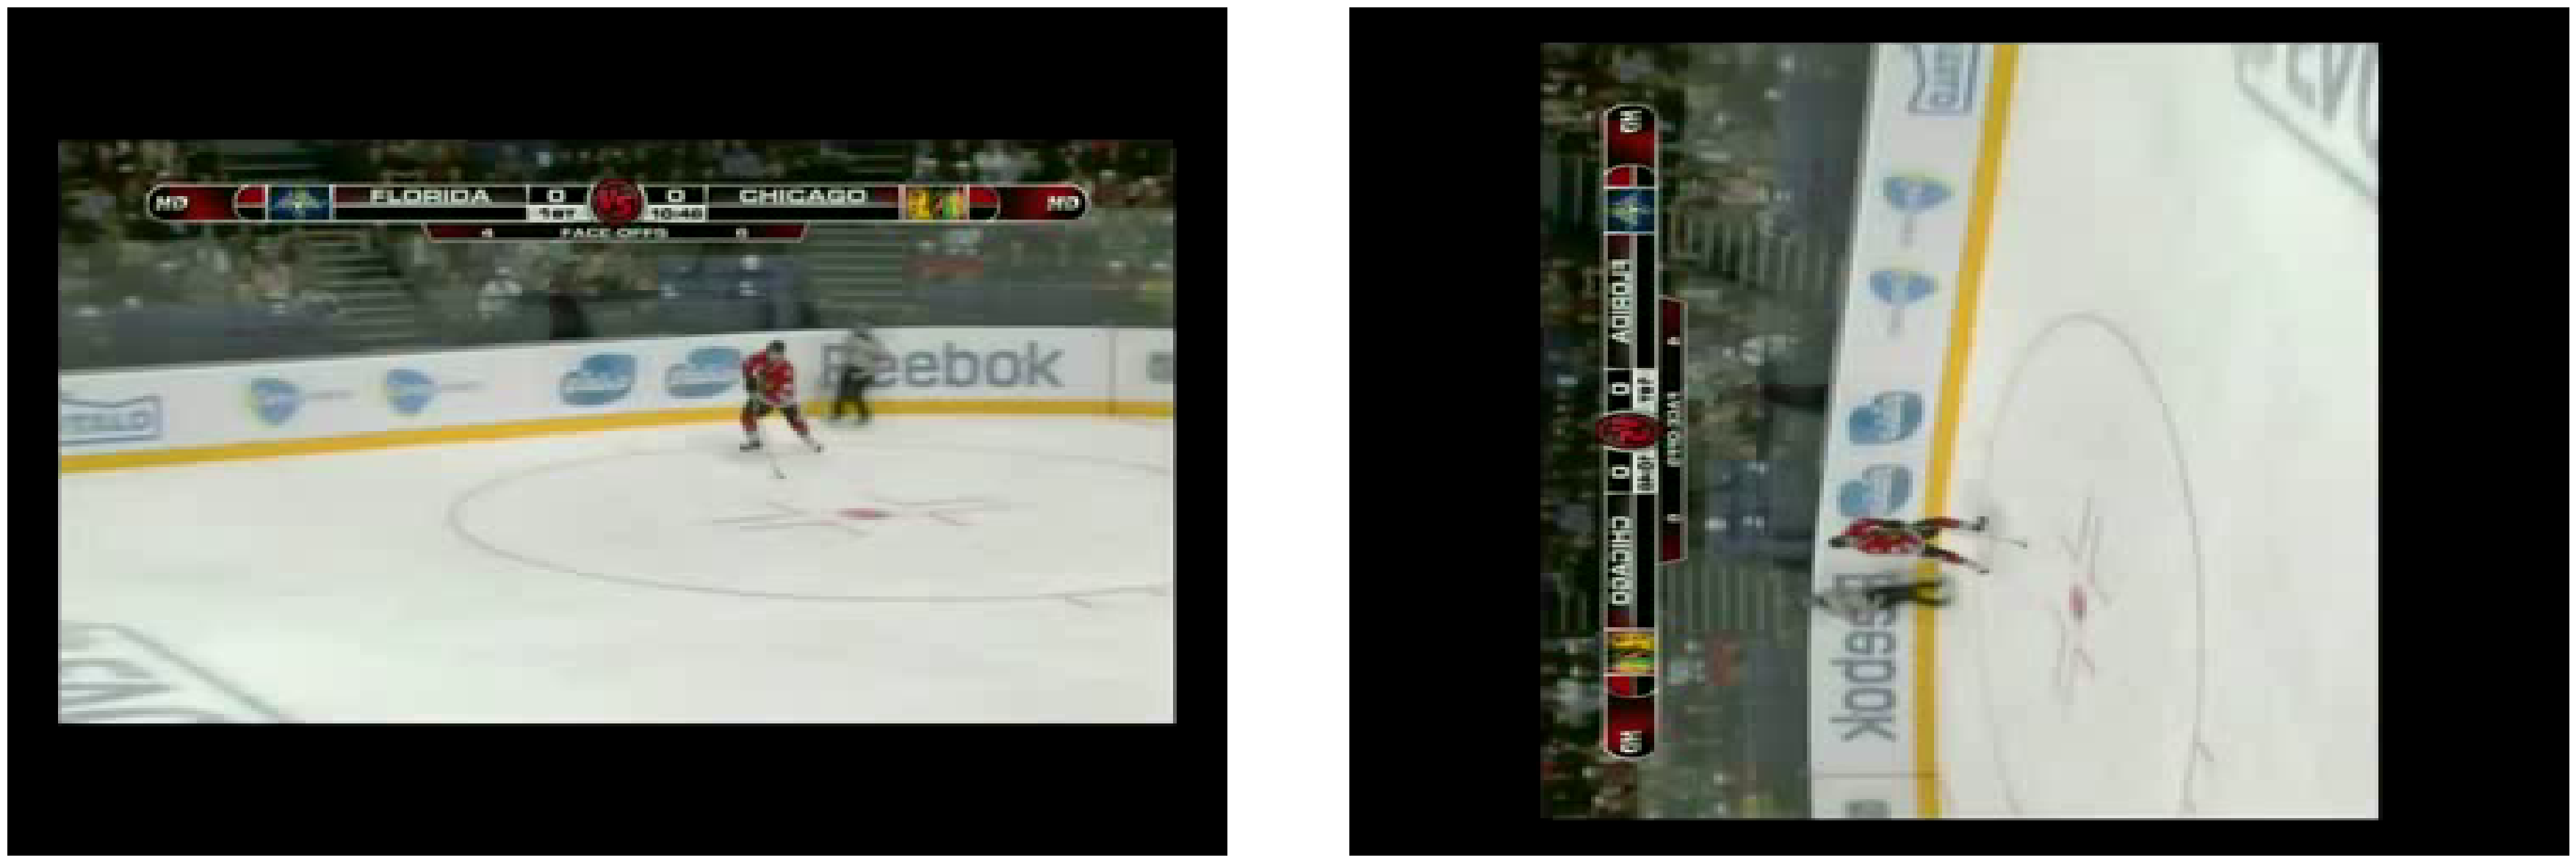

In [22]:
sample_image = video_frames[random.randint(0, 999)][0].copy()
crop_size = (330, 200)
transposed_image = transpose_image(sample_image)

print('Original image shape : ', sample_image.shape)
print('Preprocessed image shape : ', transposed_image.shape)

fig, axes = plt.subplots(1, 2, figsize=(45, 15))
axes[0].imshow(sample_image, aspect='auto')
axes[0].axis('off')
axes[1].imshow(transposed_image, aspect='auto')
axes[1].axis('off')
plt.subplots_adjust(wspace=0.1)

plt.show()

Checking if absdiff function works well:

Original image shape :  (288, 360, 3)
Preprocessed image shape :  (288, 360, 3)


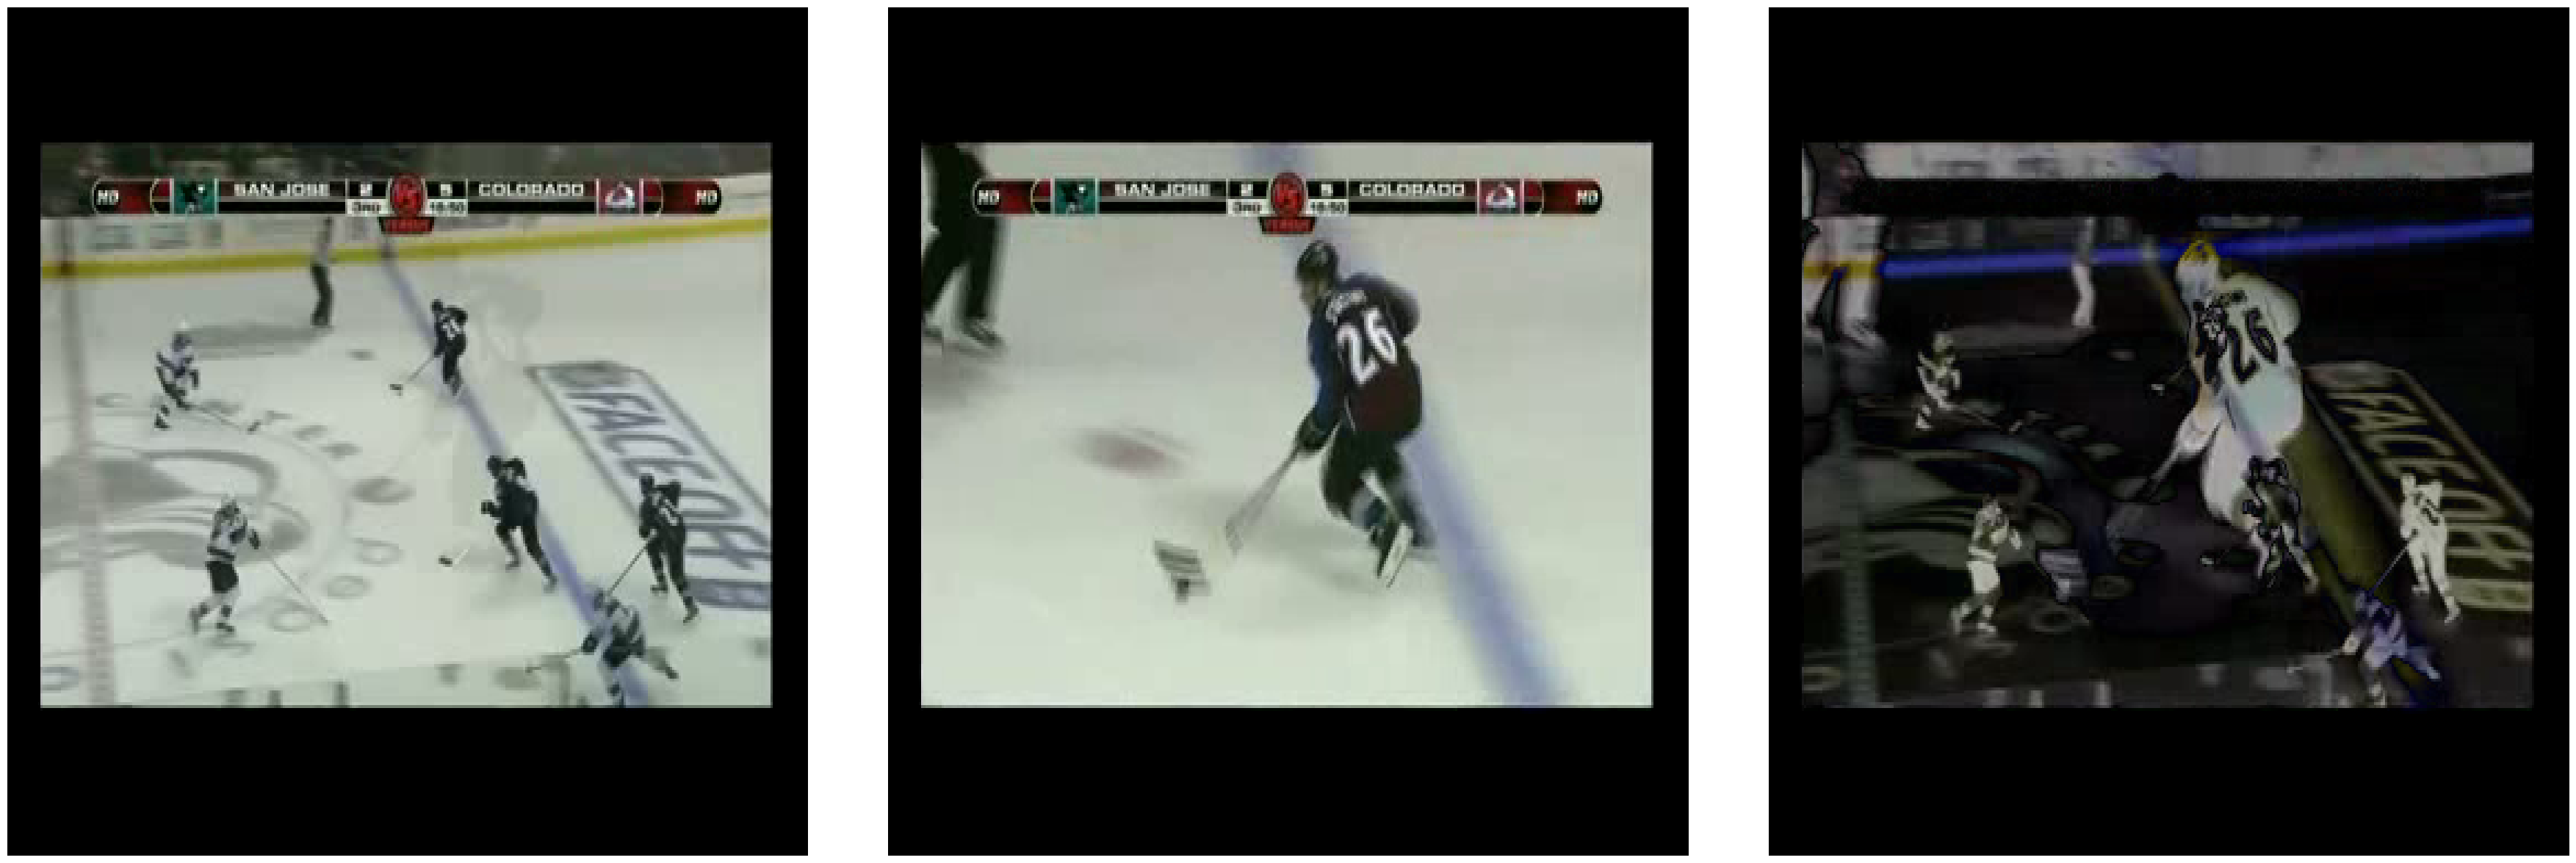

In [23]:
random_number = random.randint(0, 999)
sample_image1 = video_frames[random_number][0].copy()
sample_image2 = video_frames[random_number][1].copy()
absdiff_image = cv2.absdiff(sample_image1, sample_image2)

print('Original image shape : ', sample_image1.shape)
print('Preprocessed image shape : ', absdiff_image.shape)

fig, axes = plt.subplots(1, 3, figsize=(45, 15))
axes[0].imshow(sample_image1, aspect='auto')
axes[0].axis('off')
axes[1].imshow(sample_image2, aspect='auto')
axes[1].axis('off')
axes[2].imshow(absdiff_image, aspect='auto')
axes[2].axis('off')
plt.subplots_adjust(wspace=0.1)

plt.show()

Do the augmentations implemented above on all images (for some we use remove_dark_edges and for others we use random_crop and transpose_image):

In [24]:
numbers = list(range(1000))

new_height = 200
new_width = 330
new_frames_per_video = 10
new_size = (new_height, new_width, channels)
video_frames_ppd = np.empty((number_of_images, new_frames_per_video, new_height, new_width, channels), dtype=np.uint8)

video_labels_ppd = video_labels.copy()

for i in range(400):
    random_number = random.choice(numbers)
    numbers.remove(random_number)
    video_labels_ppd[i] = video_labels[random_number]
    for img_i in range(5):
        image1 = remove_dark_edges(video_frames[random_number][2 * img_i])
        image2 = remove_dark_edges(video_frames[random_number][2 * img_i + 1])
        video_frames_ppd[random_number][img_i] = cv2.absdiff(np.resize(image1, new_size), np.resize(image2, new_size))

crop_size = (330, 200)
for i in range(600):
    random_number = random.choice(numbers)
    numbers.remove(random_number)
    video_labels_ppd[i] = video_labels[random_number]
    for img_i in range(10):
        image1 = random_crop(video_frames[random_number][2 * img_i], crop_size)
        image2 = random_crop(video_frames[random_number][2 * img_i + 1], crop_size)
        video_frames_ppd[random_number][img_i] = cv2.absdiff(np.resize(image1, new_size), np.resize(image2, new_size))

Showing five frames of one random video:

In [25]:
video_frames_ppd.shape

(1000, 10, 200, 330, 3)

In [26]:
array_size = video_frames_ppd.nbytes

print("Memory space taken by the numpy array:", array_size, "bytes")
print("Memory space taken by the numpy array:", array_size / 1024, "kilobytes")
print("Memory space taken by the numpy array:", array_size / (1024 * 1024), "megabytes")

Memory space taken by the numpy array: 1980000000 bytes
Memory space taken by the numpy array: 1933593.75 kilobytes
Memory space taken by the numpy array: 1888.275146484375 megabytes


Checking if video_labels is fine:

In [27]:
video_labels_ppd

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,

Freeing up the previous variable video_frames:

In [28]:
video_frames = 0

Plotting some images from new preprocessed dataset:

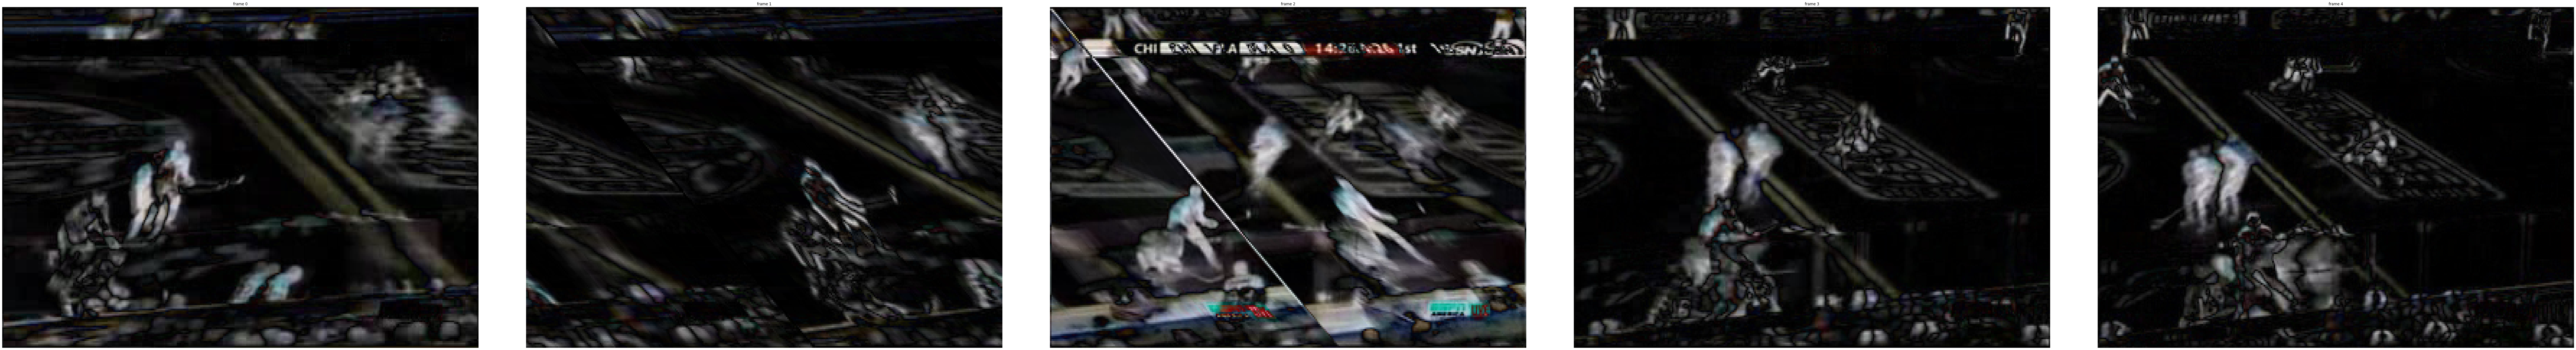

In [29]:
random_image_to_show = random.randint(0, 999)
fig, axes = plt.subplots(1, 5, figsize=(150, 20))

for i in range(5):
    axes[i].imshow(video_frames_ppd[random_image_to_show][i], aspect='auto')
    axes[i].axis('off')
    axes[i].set_title('frame ' + str(i))
plt.subplots_adjust(wspace=0.1)

plt.show()

## Building the Model

In [30]:
video_frames_ppd.shape

(1000, 10, 200, 330, 3)

Loading ResNet50 model.

In [31]:
input_shape = (200, 330, 3)
inputs = Input(shape=input_shape)
cnn_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
# cnn_model.summary()

Predict data using ResNet50 model and save them in a list

In [32]:
resnet_output = []
# to_predict = video_frames_ppd.reshape(10000, 200, 330, 3)
# print(to_predict.shape)
# resnet_output = cnn_model.predict(to_predict)
for vid in video_frames_ppd:
    result = cnn_model.predict(vid)
    resnet_output.append(result)

1/1 [==============================] - 1s 1s/step


In [33]:
video_frames_ppd = 0
resnet_output = np.array(resnet_output)
print(resnet_output.shape)

(1000, 10, 7, 11, 2048)


In [34]:
array_size = resnet_output.nbytes

print("Memory space taken by the numpy array:", array_size, "bytes")
print("Memory space taken by the numpy array:", array_size / 1024, "kilobytes")
print("Memory space taken by the numpy array:", array_size / (1024 * 1024), "megabytes")

Memory space taken by the numpy array: 6307840000 bytes
Memory space taken by the numpy array: 6160000.0 kilobytes
Memory space taken by the numpy array: 6015.625 megabytes


In [35]:
# lstm_input = resnet_output.reshape()

Loading and declaring ConvLSTM2D model and fully connected network:

In [36]:
input_shape = (10, 7, 11, 2048)
inputs = Input(shape=input_shape)
# cnn_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
# cnn_output = cnn_model(inputs)
# model_output = None
conv_lstm = ConvLSTM2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', return_sequences=False)
lstm_output = conv_lstm(inputs)
norm_output = BatchNormalization()(lstm_output)
print(norm_output.shape)
flatten_output = Flatten()(norm_output)
x = Dense(1000, activation='relu')(flatten_output)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=x)

optimizer = RMSprop()
model.compile(optimizer=optimizer, loss='binary_crossentropy',)

model.summary()

(None, 7, 11, 256)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 7, 11, 2048)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 7, 11, 256)        21234688  
                                                                 
 batch_normalization (BatchN  (None, 7, 11, 256)       1024      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 19712)             0         
                                                                 
 dense (Dense)               (None, 1000)              19713000  
                                                                 
 dense_1 (Dense)             (None, 256)  

Splitting data into train, test and validataion:

In [37]:
data = resnet_output
labels = video_labels_ppd

seed = 42 

rng = np.random.RandomState(seed)
rng.shuffle(data)
rng.shuffle(labels)

train_ratio = 0.8
train_size = int(train_ratio * len(data))
test_size = train_size + int((len(data) - train_size) * train_ratio)

X_train = data[:train_size]
y_train = labels[:train_size]
X_test = data[train_size:test_size]
y_test = labels[train_size:test_size]
X_val = data[test_size:]
y_val = labels[test_size:]

print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

Training set size: 800
Testing set size: 160
Validation set size: 40


In [38]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(800, 10, 7, 11, 2048)
(160, 10, 7, 11, 2048)
(40, 10, 7, 11, 2048)


In [39]:
physical_devices = tf.config.list_physical_devices()

gpu_devices = [device for device in physical_devices if device.device_type == 'GPU']

print("GPUs:", gpu_devices)

GPUs: []


In [40]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split the data into training, validation, and testing sets
# X_trainval, X_test, y_trainval, y_test = train_test_split(resnet_output, video_labels_ppd, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

model = Model(inputs=inputs, outputs=x)
learning_rate = 0.001
batch_size = 2
sequence_length = 10

optimizer = RMSprop(learning_rate=learning_rate)
loss = BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss)

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=10, validation_data=(X_val, y_val))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_loss, test_accuracy)

Epoch 1/10
400/400 [==============================] - 1048s 3s/step - loss: 0.9124 - val_loss: 0.6714
Epoch 2/10
400/400 [==============================] - 1014s 3s/step - loss: 0.6524 - val_loss: 0.6577
Epoch 3/10
400/400 [==============================] - 1063s 3s/step - loss: 0.6360 - val_loss: 0.6508
Epoch 4/10
400/400 [==============================] - 1072s 3s/step - loss: 0.6264 - val_loss: 0.6481
Epoch 5/10
400/400 [==============================] - 1089s 3s/step - loss: 0.6210 - val_loss: 0.6475
Epoch 6/10
400/400 [==============================] - 956s 2s/step - loss: 0.6181 - val_loss: 0.6477
Epoch 7/10
400/400 [==============================] - 930s 2s/step - loss: 0.6163 - val_loss: 0.6484
Epoch 8/10
400/400 [==============================] - 981s 2s/step - loss: 0.6153 - val_loss: 0.6491
Epoch 9/10
400/400 [==============================] - 928s 2s/step - loss: 0.6149 - val_loss: 0.6500
Epoch 10/10
5/5 [==============================] - 49s 9s/step - loss: 0.6014


TypeError: cannot unpack non-iterable float object

In [43]:
# test_loss, 
test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)

5/5 [==============================] - 48s 10s/step - loss: 0.6014
0.6013756990432739


5/5 [==============================] - 47s 9s/step


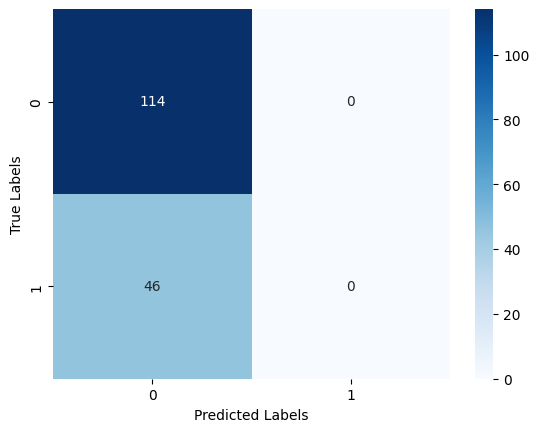

In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [46]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       114
           1       0.00      0.00      0.00        46

    accuracy                           0.71       160
   macro avg       0.36      0.50      0.42       160
weighted avg       0.51      0.71      0.59       160



C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [48]:
history.history

{'loss': [0.9124483466148376,
  0.6524311900138855,
  0.6360256671905518,
  0.6264060735702515,
  0.6210030913352966,
  0.6180561184883118,
  0.6163418889045715,
  0.6153388023376465,
  0.6148749589920044,
  0.6144779324531555],
 'val_loss': [0.6713551878929138,
  0.6576700210571289,
  0.6508387327194214,
  0.6481088995933533,
  0.647452175617218,
  0.6477094888687134,
  0.6483851075172424,
  0.6491395235061646,
  0.6499680280685425,
  0.650652289390564]}

In [49]:
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [51]:
# plt.plot(accuracy, 'bo-', label='Training Accuracy')
# plt.plot(val_accuracy, 'ro-', label='Validation Accuracy')
# plt.title('Accuracy over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

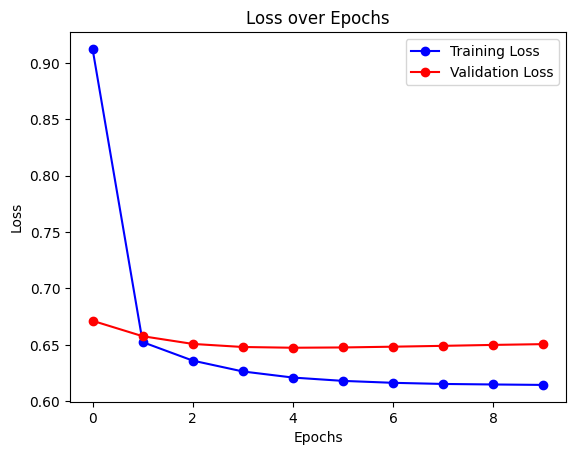

In [52]:
plt.plot(loss, 'bo-', label='Training Loss')
plt.plot(val_loss, 'ro-', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()